In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
from cmdstanpy import CmdStanModel, set_cmdstan_path
import arviz as az

In [61]:
X = pd.read_csv("../Datasets/covariates.csv")
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y.loc[:,'Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.get_dummies(X ,columns = ['Type'] ,prefix = 'type', drop_first = True)
X.loc[X['Station'] == 10171, 'Quota'] = 10

In [62]:
rows_to_drop_Y = Y[Y['Count_120'].isna()].index

# Remove corresponding rows from dataset X
X = X.drop(index=rows_to_drop_Y)
Y = Y.drop(index=rows_to_drop_Y)

# If you want to reset the index after dropping rows
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

In [63]:
stations = X['Station']
years = X['Year'] - 2009
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]

In [65]:
base_model = """

data {
  int<lower=1> N; // Number of observations
  //int<lower=1> N_miss; // Number of missing observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> station;
  array[N] int<lower=1> year;
  //array[N] int<lower=1> max_month;
  //array[N] int<lower=4, upper=10> month;

  //array[N_miss] int<lower=1> station_miss;
  //array[N_miss] int<lower=1> year_miss;
  
  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  //matrix[N_miss, P] X_miss; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  //vector[nstations] eta; // Random effects for comuni
  //vector[nyears] xi; // Random effects for years

  //real<lower=0> sigma0; // Standard deviation for beta
  //real<lower=0> sigma1; // Standard deviation for xi
  //real<lower=0> sigma2; // Standard deviation for eta
}

transformed parameters {
    vector[N] lambda;
    //vector[N_miss] lambda_miss;

    lambda = exp(X * beta); //xi[year] + eta[station]
    //lambda_miss = exp(xi[year_miss] + eta[station_miss] + X_miss * beta);
}

model {
  beta ~ normal(0, 2);
  //xi ~ normal(0, 2);
  //eta ~ normal(0, 2);

  for (i in 1:N) {
    y[i] ~ poisson(lambda[i]);  // T[0, max_month[i]]
  }
}

generated quantities{
  vector[N] log_lik;
  vector[N] y_pred;
  //vector[N_miss] y_pred_miss;

  /*
  for (i in 1:N) {
    real sum_p = 0;
    real u = uniform_rng(0, 1);
    for (b in 0:max_month[i]) {
      sum_p = sum_p + exp(poisson_lpmf(b | lambda[i]) - poisson_lcdf(max_month[i] | lambda[i]));
      if (sum_p >= u) {
        y_pred[i] = b;
        break;
      }
    }
  }
  */

  for(i in 1:N){
    log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]);
    y_pred[i] = poisson_rng(lambda[i]);
  }

  /*
  for(i in 1:N_miss){
    y_pred_miss[i] = poisson_rng(lambda_miss[i]);
  }
  */
}

"""

stan_file = "./base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

model_base = CmdStanModel(stan_file=stan_file)

23:00:16 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\base.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\base.exe
23:00:50 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\base.exe


In [66]:
X = X.drop(['Year','Station','Month'], axis  = 1)

In [67]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)
X_std.loc[:,"type_rural"] = X.loc[:,"type_rural"]
X_std.loc[:,"type_urban"] = X.loc[:,"type_urban"]
X_std.loc[:,"type_rural"] = pd.to_numeric(X_std.loc[:,"type_rural"]).astype('Int64')
X_std.loc[:,"type_urban"] = pd.to_numeric(X_std.loc[:,"type_urban"]).astype('Int64')
X_std.head()

,mean_temperature,mean_precipitation_sum,mean_precipitation_hours,mean_windspeed_10m_max,mean_radiation_sum,count_highwind,max_consecutive_highwind_days,Densità,Quota,type_rural,type_urban
0,-1.427024,-0.608034,-0.028251,0.226227,-0.005763,0.064719,-0.210751,-0.316079,-0.119963,0,1
1,-0.676275,2.540869,2.016045,0.514356,0.171209,0.590376,0.589728,-0.316079,-0.119963,0,1
2,0.428463,-0.188775,0.329701,-0.115611,0.813638,-0.101560,-0.210751,-0.316079,-0.119963,0,1
3,1.453029,-1.003430,-0.981119,0.160412,1.249078,0.027172,0.589728,-0.316079,-0.119963,0,1
4,0.529757,1.317785,0.374383,0.023923,-0.016637,0.268545,0.589728,-0.316079,-0.119963,0,1


In [68]:
data = {
    "N": len(Y),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X_std
}


fit = model_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=1500, iter_sampling=500)
posterior_az = az.from_cmdstanpy(fit)

23:01:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:03 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:04 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:06 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:08 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:09 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:10 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:12 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:13 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:14 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▍    | 00:15 Iteration: 1000 / 2000 [ 50%]  (Warmup)


chain 1 |█████▉    | 00:17 Iteration: 1100 / 2000 [ 55%]  (Warmup)


chain 1 |██████▎   | 00:18 Iteration: 1200 / 2000 [ 60%]  (Warmup)


chain 1 |███


23:01:57 - cmdstanpy - INFO - CmdStan done processing.


In [69]:
posterior_az['log_likelihood']

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 500, log_lik_dim_0: 3840)
Coordinates:
  * chain          (chain) int32 0 1 2 3
  * draw           (draw) int32 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * log_lik_dim_0  (log_lik_dim_0) int32 0 1 2 3 4 ... 3835 3836 3837 3838 3839
Data variables:
    log_lik        (chain, draw, log_lik_dim_0) float64 -2.25 -3.685 ... -0.3114
Attributes:
    created_at:                 2023-12-18T22:02:06.771489
    arviz_version:              0.17.0.dev0
    inference_library:          cmdstanpy
    inference_library_version:  1.2.0

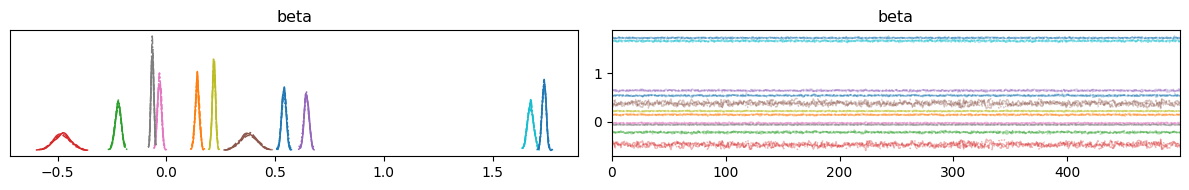

In [70]:
az.plot_trace(posterior_az, var_names = ['beta'], compact=True)
plt.tight_layout()
plt.show()

In [71]:
posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [ ]:
lam = posterior_az['posterior']['lambda']
lam

<xarray.DataArray 'lambda' (chain: 4, draw: 200, lambda_dim_0: 3840)>
array([[[ 2.22647 ,  3.9408  , 11.1418  , ...,  3.03896 ,  0.608219,
          0.288691],
        [ 2.21641 ,  3.95191 , 11.2751  , ...,  3.02362 ,  0.618585,
          0.300997],
        [ 2.22081 ,  3.73223 , 11.1547  , ...,  3.04412 ,  0.613614,
          0.3089  ],
        ...,
        [ 2.21531 ,  3.8367  , 11.1191  , ...,  3.06688 ,  0.617404,
          0.303436],
        [ 2.20795 ,  3.74987 , 10.9305  , ...,  3.05416 ,  0.617979,
          0.309381],
        [ 2.21511 ,  3.78953 , 11.0156  , ...,  3.08604 ,  0.625789,
          0.308985]],

       [[ 2.25334 ,  3.8954  , 10.9447  , ...,  2.99779 ,  0.61262 ,
          0.302814],
        [ 2.25883 ,  3.76278 , 11.0333  , ...,  3.01728 ,  0.607614,
          0.306502],
        [ 2.12688 ,  3.85266 , 11.2485  , ...,  3.13743 ,  0.614538,
          0.289339],
...
        [ 2.24956 ,  3.9385  , 11.2649  , ...,  2.99913 ,  0.608788,
          0.295446],
        [ 2.19902 ,  3.78684 , 11.0122  , ...,  3.03934 ,  0.615457,
          0.303289],
        [ 2.26753 ,  3.80392 , 11.0673  , ...,  3.04237 ,  0.622387,
          0.305302]],

       [[ 2.24715 ,  3.87391 , 11.2224  , ...,  3.03857 ,  0.622692,
          0.303284],
        [ 2.18937 ,  3.82755 , 11.0619  , ...,  3.0829  ,  0.606555,
          0.298081],
        [ 2.22215 ,  3.90492 , 11.1361  , ...,  3.03337 ,  0.601096,
          0.292069],
        ...,
        [ 2.30284 ,  3.85885 , 11.1815  , ...,  3.01396 ,  0.609072,
          0.295464],
        [ 2.21216 ,  3.88097 , 11.1642  , ...,  3.04294 ,  0.604491,
          0.289677],
        [ 2.1843  ,  3.74164 , 11.0063  , ...,  3.0999  ,  0.621257,
          0.308469]]])
Coordinates:
  * chain         (chain) int32 0 1 2 3
  * draw          (draw) int32 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * lambda_dim_0  (lambda_dim_0) int32 0 1 2 3 4 5 ... 3835 3836 3837 3838 3839

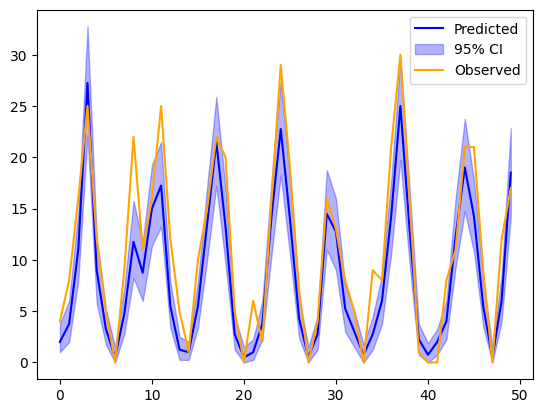

In [72]:
preds_y = posterior_az['posterior']['y_pred'].mean(axis=0)
y_star = preds_y.median(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)
xx = np.arange(0, 50)
plt.plot(xx, y_star[xx], label="Predicted", color='blue')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI", color='blue')
plt.plot(xx, Y.loc[xx, 'Count_120'], label="Observed", color='orange')
plt.legend()
plt.show()

In [73]:
outliers = np.where(np.abs(y_star - Y['Count_120']) > 10)[0]
print(outliers)
print(outliers.shape)

[   8   56  132  238  310  346  383  384  391  410  422  429  478  519
  599  605  647  648  739  747  752  753  757  758  769  770  775  776
  781  782  833  842  876  877  913  925  926  931  943  957  958  963
  964  969  976  977  978  984  985  990  991  992  997  998  999 1021
 1065 1066 1073 1078 1079 1080 1101 1136 1142 1143 1171 1222 1260 1324
 1332 1386 1526 1583 1591 1710 1718 1723 1724 1725 1731 1743 1744 1745
 1750 1756 1757 1758 1763 1769 1770 1774 1777 1778 1783 1784 1786 1790
 1791 1792 1857 1859 1871 1878 1879 1889 1972 1983 2020 2026 2033 2041
 2047 2055 2073 2090 2105 2137 2140 2155 2175 2227 2234 2259 2305 2306
 2359 2399 2462 2464 2574 2580 2587 2622 2648 2659 2661 2662 2663 2668
 2673 2684 2685 2687 2695 2698 2707 2708 2709 2713 2714 2715 2718 2719
 2721 2722 2723 2730 2733 2736 2737 2742 2748 2749 2755 2773 2780 2812
 2818 2819 2824 2825 2826 2840 2846 2847 2851 2857 2858 2859 2864 2865
 2866 2867 2871 2872 2873 2878 2879 2880 2881 2885 2886 2887 2892 2893
 2894 

In [74]:
outliers = np.where((y_star_low > Y['Count_120']) | (y_star_up < Y['Count_120']))[0]
print(outliers)
print(outliers.shape)

[   0    1    2 ... 3836 3837 3838]
(2145,)


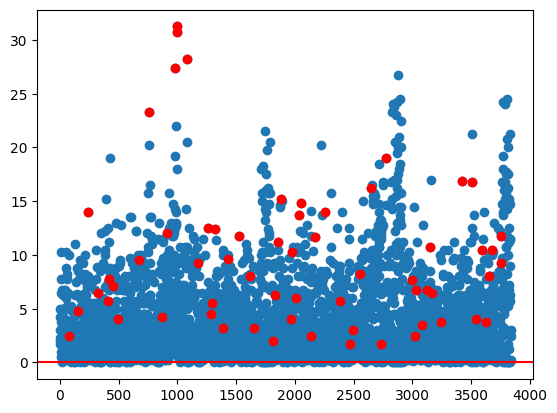

[   8   56  132  238  310  346  383  384  391  410  422  429  478  519
  599  605  647  648  739  747  752  753  757  758  769  770  775  776
  781  782  833  842  876  877  913  925  926  931  943  957  958  963
  964  969  976  977  978  984  985  990  991  992  997  998  999 1021
 1065 1066 1073 1078 1079 1080 1101 1136 1142 1143 1171 1222 1260 1324
 1332 1386 1526 1583 1591 1710 1718 1723 1724 1725 1731 1743 1744 1745
 1750 1756 1757 1758 1763 1769 1770 1774 1777 1778 1783 1784 1786 1790
 1791 1792 1857 1859 1871 1878 1879 1889 1972 1983 2020 2026 2033 2041
 2047 2055 2073 2090 2105 2137 2140 2155 2175 2227 2234 2259 2305 2306
 2359 2399 2462 2464 2574 2580 2587 2622 2648 2659 2661 2662 2663 2668
 2673 2684 2685 2687 2695 2698 2707 2708 2709 2713 2714 2715 2718 2719
 2721 2722 2723 2730 2733 2736 2737 2742 2748 2749 2755 2773 2780 2812
 2818 2819 2824 2825 2826 2840 2846 2847 2851 2857 2858 2859 2864 2865
 2866 2867 2871 2872 2873 2878 2879 2880 2881 2885 2886 2887 2892 2893
 2894 

In [76]:
#identifying outliers through residuals
#We identify outliers by looking at the observations
#that have a large difference between the observed and
#predicted values

idx_over_30 = np.where(y_star> 30)[0]

residuals = np.abs(Y['Count_120'] - y_star)

#plot these residuals

plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_30, residuals[idx_over_30], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

outliers = np.where(residuals > 10)[0]
print(outliers)
print(outliers.shape)

total_outliers = np.unique(np.concatenate((outliers, idx_over_30)))
print(total_outliers)
print(total_outliers.shape)

In [77]:
# plot a map of the residuals where you can easily identify ste stations with high residuals

mask = residuals > 10
mask = mask.astype(int)

# group by station
mask = mask.groupby(stations).sum()
mask = mask.reset_index()
mask.columns = ['Station', 'Count']
mask = mask.sort_values(by='Count', ascending=False)
mask = mask.reset_index(drop=True)
print(mask)

mask_2 = residuals > 10
mask_2 = mask_2.astype(int)

# group by year
mask_2 = mask_2.groupby(years).sum()
mask_2 = mask_2.reset_index()
mask_2.columns = ['Year', 'Count']
mask_2 = mask_2.sort_values(by='Count', ascending=False)
mask_2 = mask_2.reset_index(drop=True)
print(mask_2)


    Station  Count
0     10025     34
1     12020     33
2      9991     26
3      6804     25
4      5739     20
5      9997      9
6      6884      8
7      5735      7
8      5742      7
9     10437      6
10     5732      6
11     5749      5
12     9972      5
13    10584      5
14     9861      5
15     6904      5
16     5719      5
17     6818      5
18     5738      4
19     5730      4
20     5721      3
21    10463      3
22     9899      3
23    10454      3
24    10171      3
25    10081      2
26    10282      2
27    10288      2
28    10041      2
29     5707      2
30     9856      2
31     6665      2
32     5952      2
33     5750      2
34     9882      1
35     5710      1
36     6582      1
37     5960      1
38     5725      1
39     5718      1
40     5717      1
41     6832      1
42     9925      0
43     6691      0
44    10270      0
    Year  Count
0     13     43
1      3     27
2      9     27
3      2     26
4     11     24
5     12     23
6     10     2

In [78]:
stations_to_rm = mask[mask['Count'] > 10]['Station'].values
print(stations_to_rm)

[10025 12020  9991  6804  5739]


In [79]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

3.78662109375
29.53680419921875


In [80]:
transformed_stations = pd.Series(transformed_stations)
years = pd.Series(years)

data_no_out = {
    "N": len(Y) - len(total_outliers),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations.drop(index=total_outliers),
    "year": years.drop(index=total_outliers),
    "y": Y['Count_120'].drop(index=total_outliers),
    "X": X_std.drop(index=total_outliers)
}


fit_2 = model_base.sample(data=data_no_out, chains=4, parallel_chains=4, 
    iter_warmup=1500, iter_sampling=500)
posterior_az_2 = az.from_cmdstanpy(fit_2) 

23:21:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:02 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:03 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:05 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:07 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:08 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:10 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████      | 00:11 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████▌     | 00:12 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:14 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▍    | 00:15 Iteration: 1000 / 2000 [ 50%]  (Warmup)


chain 1 |█████▉    | 00:16 Iteration: 1100 / 2000 [ 55%]  (Warmup)


chain 1 |██████▎   | 00:17 Iteration: 1200 / 2000 [ 60%]  (Warmup)


chain 1 |██████▊   | 00:19 Iteration: 1300 / 2000 [ 65%]  (Warmup)


chain 


23:22:24 - cmdstanpy - INFO - CmdStan done processing.


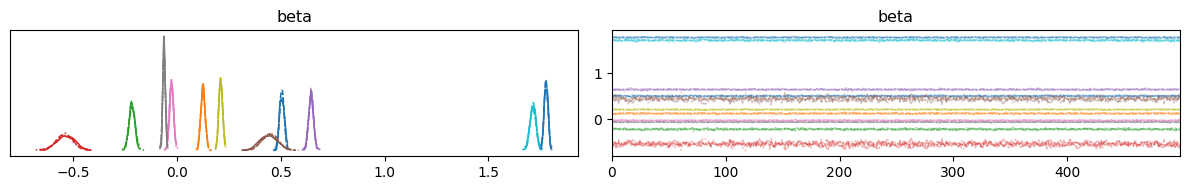

In [81]:
az.plot_trace(posterior_az_2, var_names = ['beta'], compact=True)
plt.tight_layout()
plt.show()

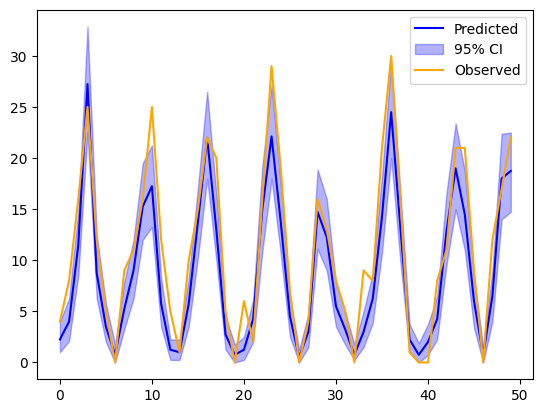

In [82]:
Y_no_out = Y.drop(index=total_outliers)
Y_no_out = Y_no_out.reset_index(drop=True)

preds_y_2 = posterior_az_2['posterior']['y_pred'].mean(axis=0)
y_star_2 = preds_y_2.median(axis=0)
y_star_up_2 = np.percentile(preds_y_2, 97.5, axis=0)
y_star_low_2 = np.percentile(preds_y_2, 2.5, axis=0)
xx = np.arange(0, 50)
plt.plot(xx, y_star_2[xx], label="Predicted", color='blue')
plt.fill_between(xx, y_star_low_2[xx], y_star_up_2[xx], alpha=0.3, label="95% CI", color='blue')
plt.plot(xx, Y_no_out.loc[xx, 'Count_120'], label="Observed", color='orange')
plt.legend()
plt.show()

In [86]:
outliers_2 = np.where((y_star_low_2 > Y_no_out['Count_120']) | (y_star_up_2 < Y_no_out['Count_120']))[0]
print(outliers)
print(outliers.shape)

[   8   56  132  238  310  346  383  384  391  410  422  429  478  519
  599  605  647  648  739  747  752  753  757  758  769  770  775  776
  781  782  833  842  876  877  913  925  926  931  943  957  958  963
  964  969  976  977  978  984  985  990  991  992  997  998  999 1021
 1065 1066 1073 1078 1079 1080 1101 1136 1142 1143 1171 1222 1260 1324
 1332 1386 1526 1583 1591 1710 1718 1723 1724 1725 1731 1743 1744 1745
 1750 1756 1757 1758 1763 1769 1770 1774 1777 1778 1783 1784 1786 1790
 1791 1792 1857 1859 1871 1878 1879 1889 1972 1983 2020 2026 2033 2041
 2047 2055 2073 2090 2105 2137 2140 2155 2175 2227 2234 2259 2305 2306
 2359 2399 2462 2464 2574 2580 2587 2622 2648 2659 2661 2662 2663 2668
 2673 2684 2685 2687 2695 2698 2707 2708 2709 2713 2714 2715 2718 2719
 2721 2722 2723 2730 2733 2736 2737 2742 2748 2749 2755 2773 2780 2812
 2818 2819 2824 2825 2826 2840 2846 2847 2851 2857 2858 2859 2864 2865
 2866 2867 2871 2872 2873 2878 2879 2880 2881 2885 2886 2887 2892 2893
 2894 

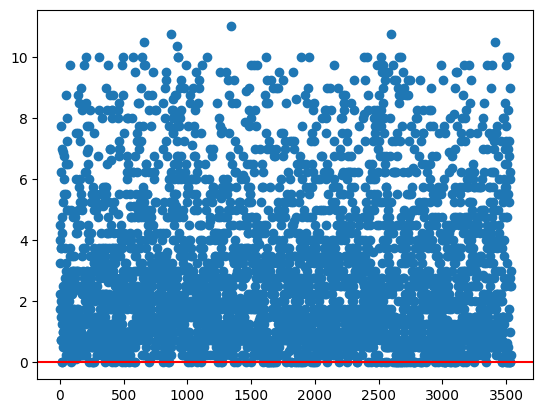

In [88]:
residuals_2 = np.abs(Y_no_out['Count_120'] - y_star_2)

#plot these residuals

plt.scatter(np.arange(0, len(residuals_2)),residuals_2)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [89]:
mae_2 = np.mean(residuals_2)
print(mae_2)
mse_2 = np.mean(residuals_2**2)
print(mse_2)

2.99077868852459
14.999995583663086


In [92]:
transformed_stations = pd.Series(transformed_stations)
years = pd.Series(years)

data_no_stat = {
    "N": len(Y.loc[~Y['idSensore'].isin(stations_to_rm),:]),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45 - len(stations_to_rm),
    "station": transformed_stations.loc[~Y['idSensore'].isin(stations_to_rm)],
    "year": years.loc[~Y['idSensore'].isin(stations_to_rm)],
    "y": Y.loc[~Y['idSensore'].isin(stations_to_rm),'Count_120'],
    "X": X_std.loc[~Y['idSensore'].isin(stations_to_rm),:]
}


fit_3 = model_base.sample(data=data_no_stat, chains=4, parallel_chains=4, 
    iter_warmup=1500, iter_sampling=500)
posterior_az_3 = az.from_cmdstanpy(fit_3) 

23:28:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:02 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:03 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:05 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:06 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:08 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:09 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:10 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:12 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:13 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▍    | 00:14 Iteration: 1000 / 2000 [ 50%]  (Warmup)


chain 1 |█████▉    | 00:15 Iteration: 1100 / 2000 [ 55%]  (Warmup)


chain 1 |██████▎   | 00:16 Iteration: 1200 / 2000 [ 60%]  (Warmup)


chain 1 |██████▊   | 00:18 Iteration: 1300 / 2000 [ 65%]  (Warmup)


chain 1 


23:29:08 - cmdstanpy - INFO - CmdStan done processing.


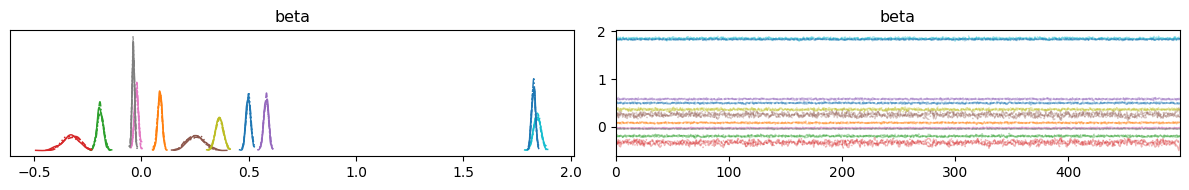

In [93]:
az.plot_trace(posterior_az_3, var_names = ['beta'],  compact=True)
plt.tight_layout()
plt.show()

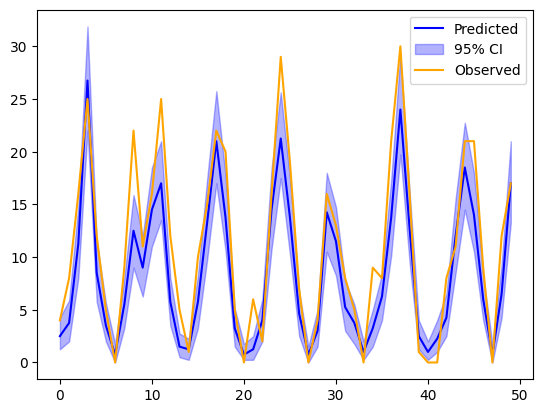

In [94]:
Y_no_stat = Y.loc[~Y['idSensore'].isin(stations_to_rm),:]
Y_no_stat = Y_no_stat.reset_index(drop=True)

preds_y_3 = posterior_az_3['posterior']['y_pred'].mean(axis=0)
y_star_3 = preds_y_3.median(axis=0)
y_star_up_3 = np.percentile(preds_y_3, 97.5, axis=0)
y_star_low_3 = np.percentile(preds_y_3, 2.5, axis=0)
xx = np.arange(0, 50)
plt.plot(xx, y_star_3[xx], label="Predicted", color='blue')
plt.fill_between(xx, y_star_low_3[xx], y_star_up_3[xx], alpha=0.3, label="95% CI", color='blue')
plt.plot(xx, Y_no_stat.loc[xx, 'Count_120'], label="Observed", color='orange')
plt.legend()
plt.show()

In [96]:
outliers_3 = np.where((y_star_low_3 > Y_no_stat['Count_120']) | (y_star_up_3 < Y_no_stat['Count_120']))[0]
print(outliers)
print(outliers.shape)

[   8   56  132  238  310  346  383  384  391  410  422  429  478  519
  599  605  647  648  739  747  752  753  757  758  769  770  775  776
  781  782  833  842  876  877  913  925  926  931  943  957  958  963
  964  969  976  977  978  984  985  990  991  992  997  998  999 1021
 1065 1066 1073 1078 1079 1080 1101 1136 1142 1143 1171 1222 1260 1324
 1332 1386 1526 1583 1591 1710 1718 1723 1724 1725 1731 1743 1744 1745
 1750 1756 1757 1758 1763 1769 1770 1774 1777 1778 1783 1784 1786 1790
 1791 1792 1857 1859 1871 1878 1879 1889 1972 1983 2020 2026 2033 2041
 2047 2055 2073 2090 2105 2137 2140 2155 2175 2227 2234 2259 2305 2306
 2359 2399 2462 2464 2574 2580 2587 2622 2648 2659 2661 2662 2663 2668
 2673 2684 2685 2687 2695 2698 2707 2708 2709 2713 2714 2715 2718 2719
 2721 2722 2723 2730 2733 2736 2737 2742 2748 2749 2755 2773 2780 2812
 2818 2819 2824 2825 2826 2840 2846 2847 2851 2857 2858 2859 2864 2865
 2866 2867 2871 2872 2873 2878 2879 2880 2881 2885 2886 2887 2892 2893
 2894 

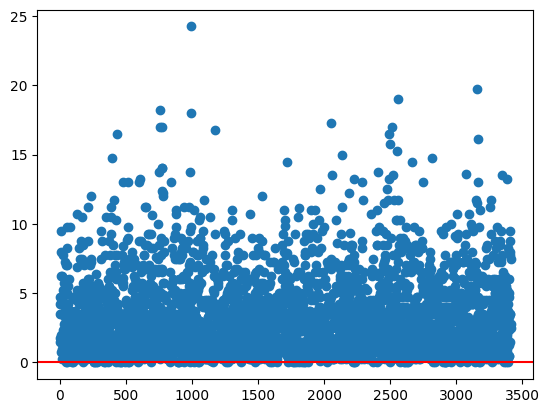

In [98]:
residuals_3 = np.abs(Y_no_stat['Count_120'] - y_star_3)

#plot these residuals
plt.scatter(np.arange(0, len(residuals_3)),residuals_3)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [99]:
mae_3 = np.mean(residuals_3)
print(mae_3)
mse_3 = np.mean(residuals_3**2)
print(mse_3)

3.2232273659537065
18.470182940228536


In [100]:
print("WAIC_1: ", az.waic(posterior_az, var_name='log_lik'))
print("WAIC_2: ", az.waic(posterior_az_2, var_name='log_lik'))
print("WAIC_3: ", az.waic(posterior_az_3, var_name='log_lik'))
print("LOO_1: ", az.loo(posterior_az, var_name='log_lik'))
print("LOO_2: ", az.loo(posterior_az_2, var_name='log_lik'))
print("LOO_3: ", az.loo(posterior_az_3, var_name='log_lik'))

c:\Users\matte\anaconda3\envs\stan\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC_1:  Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -13615.22   237.13
p_waic       41.54        -

There has been a warning during the calculation. Please check the results.
WAIC_2:  Computed from 2000 posterior samples and 3538 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -9953.88   109.05
p_waic       22.59        -
WAIC_3:  Computed from 2000 posterior samples and 3413 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -9659.69    93.41
p_waic       23.00        -
LOO_1:  Computed from 2000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -13615.31   237.13
p_loo       41.64        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0

In [ ]:
eta = posterior_az['posterior']['eta']
eta
len(np.unique(stations))

KeyError: 'eta'

In [ ]:
inference = []
for i in range(len(np.unique(stations))):
    ar1 = eta[0, :, i]
    ar2 = eta[1, :, i]
    ar3 = eta[2, :, i]
    ar4 = eta[3, :, i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference.append(current_iteration_df)

len(current_iteration_df)
len(inference)

NameError: name 'eta' is not defined

In [ ]:
df = pd.DataFrame(inference).transpose()
df.shape
df.columns = np.unique(stations)
df.columns.values

array([ 5707,  5710,  5717,  5718,  5719,  5721,  5725,  5730,  5732,
        5735,  5738,  5739,  5742,  5749,  5750,  5952,  5960,  6582,
        6665,  6691,  6804,  6818,  6832,  6884,  6904,  9856,  9861,
        9882,  9899,  9925,  9972,  9991,  9997, 10025, 10041, 10081,
       10171, 10270, 10282, 10288, 10437, 10454, 10463, 10584, 12020],
      dtype=int64)

In [ ]:
csv_path = '../Datasets/eta_120.csv'
data = pd.DataFrame(df)
# Save the DataFrame to a CSV file
data.to_csv(csv_path, index=False)